In [10]:
from vit_model import create_vit_classifier, Patches

In [17]:
import os

import tensorflow as tf
import keras
from keras import ops
from keras import layers

import numpy as np
import matplotlib.pyplot as plt

2025-02-03 12:35:33.808705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
print("gpu: ",tf.config.list_physical_devices('GPU'))

gpu:  []


2025-02-03 12:35:58.140420: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
# data prep
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [13]:
# hyperparams

params = {}
params["num_classes"] = 100
params["input_shape"] = (32, 32, 3)
params["learning_rate"] = 0.001
params["weight_decay"] = 0.0001
params["batch_size"] = 256
params["num_epochs"] = 10  # For real training, use num_epochs=100. 10 is a test value
params["image_size"] = 72  # We'll resize input images to this size
params["patch_size"] = 6  # Size of the patches to be extract from the input images
params["num_patches"] = (params["image_size"] // params["patch_size"]) ** 2
params["projection_dim"] = 64
params["num_heads"] = 4
params["transformer_units"] = [
    params["projection_dim"] * 2,
    params["projection_dim"],
]  # Size of the transformer layers
params["transformer_layers"] = 8
params["mlp_head_units"] = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


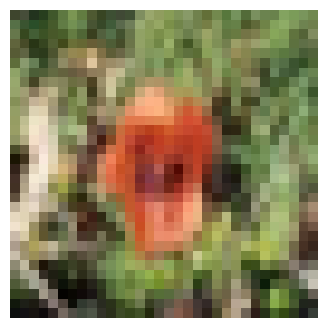

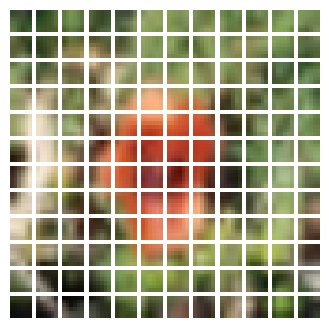

In [14]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

# resize
resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(params["image_size"], params["image_size"])
)
patches = Patches(params["patch_size"])(resized_image)
print(f'Image size: { params["image_size"]} X {params["image_size"]}')
print(f'Patch size: { params["patch_size"]} X {params["patch_size"]}')
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (params["patch_size"], params["patch_size"], 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [15]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=params["learning_rate"], weight_decay=params["weight_decay"]
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=params["batch_size"],
        epochs=params["num_epochs"],
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [16]:
# run

vit_classifier = create_vit_classifier(params)
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

Epoch 1/10
 12/176 ━━━━━━━━━━━━━━━━━━━━ 18:20 7s/step - accuracy: 0.0106 - loss: 8.6138 - top-5-accuracy: 0.0454

KeyboardInterrupt: 